# Wikipedia recommender system 


**Created by:**
<ul>
<li>Bartosz Maślanka 144091 
<li>Kajetan Kubik 145451
</ul>    
    

# Table of contents
1. [Crawling and scraping ](#scraping)
2. [Stemming, lemmatization](#stemming)
3. [Similarities](#similarities)
4. [Examples](#examples)

In [219]:
from bs4 import BeautifulSoup
from bs4.element import Tag, ResultSet
import requests
from requests import Response
from pandas import Series,DataFrame
import pandas as pd
from typing import List, Tuple

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, wordpunct_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go
import pickle
import numpy as np



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ModuleNotFoundError: No module named 'wordcloud'

# Crawling and scraping  <a name="scraping"></a>

## 1. Selcting topic of our dataset

We decided to select James Bond world, we used [James Bond Fandom site](https://jamesbond.fandom.com/) to scrape over 1500 content of websites to our dataset.

In [16]:
BASE_URL: str = 'https://jamesbond.fandom.com/'
NUM_OF_PAGES: int = 1500 

## Function to get list of sites with desirable content

We begin from scraping list of part of the sites of desire content which can be fund [here](https://jamesbond.fandom.com/wiki/Special:AllPages).

In [3]:
def get_list_of_sites(base_url: str, number_of_pages: int) -> List[str]:
    strat_url: str = 'wiki/Special:AllPages'
    site: response = requests.get(base_url + strat_url)
    list_of_pages: List[str] = []
    while len(list_of_pages) <= number_of_pages:
        soup: BeautifulSoup = BeautifulSoup(site.content)
        all_links_on_the_page: Tag = soup.find_all('ul', {'class': 'mw-allpages-chunk'})[0]
        for a_element in all_links_on_the_page.find_all('a', href=True):
            list_of_pages.append(a_element['href'])
        next_buttton: ResultSet = soup.find_all('a',{'title': 'Special:AllPages'})
        for i in next_buttton:
            if i.text.startswith('Next page'):
                url: str = base_url + '/' + i['href']
                site: Response = requests.get(url)
                break
        list_of_pages: List[str] = list(set(list_of_pages))
    return list_of_pages
list_of_pages: List[str] = get_list_of_sites(BASE_URL, NUM_OF_PAGES)

Total number of sites:

In [4]:
len(list_of_pages)

1725

## Function which creates dict of content from given sites

We take paragraphs from websites, which do not contain other tags then *a*, *b*, *i*, *span*, because we observe that usually when other tags are, sites contain some useless informations like tables or description of images.  

In [5]:
def create_dict_of_content(list_of_sites: List[str], base_url: str) -> dict:
    headers = {"User-Agent": "Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.2.8) Gecko/20100722 Firefox/3.6.8 GTB7.1 (.NET CLR 3.5.30729)", "Referer": "http://example.com"}
    dict_of_content = dict()
    for site in tqdm(list_of_sites):
        response: Response = requests.get(base_url + '/'+ site, headers=headers, timeout=5)
        soup: BeautifulSoup = BeautifulSoup(response.content, 'html.parser')
        text: str = ''
        for i in soup.find_all('p', attrs={'class': None}):
            if set(i.findChildren(['a', 'b', 'i', 'span'])) == set(i.findChildren()):   
                text += i.text                                                  
                dict_of_content[site] = text
    return dict_of_content

dict_of_content = create_dict_of_content(list_of_pages, BASE_URL)

100%|████████████████████████████████████████████████| 1725/1725 [20:39<00:00,  1.39it/s]


Since downloading the content of pages takes a long time, we save the generated dict for optimization purposes the next time the program is launched

In [9]:
def save_dict_to_file(dict_of_content: dict, output_file_name: str = 'dict_of_content') -> None:
    with open(f'{output_file_name}.pkl', 'wb') as f:
        pickle.dump(dict_of_content, f)

# save_dict_to_file(dict_of_content)
        
def load_file_to_dict(input_file_name: str) -> dict:
    with open(input_file_name, 'rb') as f:
        loaded_dict = pickle.load(f)
    return loaded_dict

loaded_dict = load_file_to_dict('dict_of_content.pkl')

Example of [website](https://jamesbond.fandom.com/wiki/Graves_Corporation) content.

In [10]:
loaded_dict['/wiki/Graves_Diamonds']

'Graves Corporation, also known as Graves Diamonds, was a fictional diamonds mining company operating from Iceland. Supposedly founded by wealthy entrepreneur, Gustav Graves, an orphan brought up in the diamond mines of Argentina, Graves Corporation is based around an unexpected and highly improbable diamond mine in the wastelands of Iceland. However, in reality, the diamond mine is a front for the laundering of African conflict diamonds by surgically altered North Korean colonel Tan-Sun Moon. The organization was created for the 2002 James Bond\xa0film,\xa0Die Another Day, and its accompanying novelisation, penned by Raymond Benson. It was also later re-imagined for the 2012 video-game, 007 Legends.\n'

## Covert dict of sites & content to DataFrame for preprocess

In [13]:
df = DataFrame(loaded_dict.items(),columns=['Site','Text'])
df.head()

,Site,Text
0,/wiki/Arab_Beauty_1,This Arab Beauty was a fictional unnamed woman...
1,/wiki/BMW,Bayerische Motoren Werke AG (BMW; English: Bav...
2,/wiki/Annabel_Chung_(Marguerite_LeWars),Annabel Chung is a fictional freelance photogr...
3,/wiki/Heracles,Heracles was a fictional DNA-targeting assassi...
4,/wiki/Casino_Royale_(novel),Casino Royale is the first novel written by Ia...


Save results to csv

In [9]:
df.to_csv('sites_with_text.csv')

Load from CSV file

In [10]:
df = pd.read_csv('sites_with_text.csv', keep_default_na=False)
df = df.drop(columns = ['Unnamed: 0'])
df

,Site,Text
0,/wiki/Arab_Beauty_1,This Arab Beauty was a fictional unnamed woman...
1,/wiki/BMW,Bayerische Motoren Werke AG (BMW; English: Bav...
2,/wiki/Annabel_Chung_(Marguerite_LeWars),Annabel Chung is a fictional freelance photogr...
3,/wiki/Heracles,Heracles was a fictional DNA-targeting assassi...
4,/wiki/Casino_Royale_(novel),Casino Royale is the first novel written by Ia...
...,...,...
1598,/wiki/BBC,\nThe British Broadcasting Corporation (BBC) i...
1599,/wiki/Becoming_Bond_(documentary),Christopher LeggettJosh GreenbaumThe stranger-...
1600,/wiki/General_Orlov,Lieutenant-General Orlov was a fictional Sovie...
1601,/wiki/Guido_Carnifex,Guido Carnifex was a Sardinian serving in the ...


# Stemming, lemmatization <a name="stemming"></a>

## Preprocessing our dataset

Our preprocessing of each content of sites looks like this:
- divides string into tokens
- on each token use Porter Stemming Algorithm
- delete all non alphabetic tokens, and put them into lower case
- delete all tokens thats are *stopwords*
- return list of tokens

(for data this process could take 2 min)


In [14]:
porter = PorterStemmer() #'caring ->care'
lancaster = LancasterStemmer()
wordnet = WordNetLemmatizer() #'caring -> car'

In [17]:
def custom_stemmer(string: str) -> List[str]:
    token = wordpunct_tokenize(string)
    stemed: List[str] = [porter.stem(word) for word in token]
    no_alpha: List[str] = [word.lower() for word in stemed if word.isalpha()]
    clean: List[str] = [word for word in no_alpha if word not in stopwords.words('english')]
    return clean
print(f"URL: {BASE_URL + df.loc[7]['Site']}")
words = custom_stemmer(df.loc[7]['Text'])
print(f"RESULTS: {words}")

URL: https://jamesbond.fandom.com//wiki/First_Lieutenant_(Boeing_747)
RESULTS: ['first', 'lieuten', 'wa', 'fiction', 'flight', 'engin', 'boe', 'carri', 'moonrak', 'shuttl', 'unit', 'state', 'great', 'britain', 'jame', 'bond', 'film', 'moonrak', 'wa', 'portray', 'late', 'french', 'actor', 'deni', 'seurat', 'togeth', 'british', 'royal', 'air', 'forc', 'offic', 'richard', 'lieuten', 'colonel', 'kennedi', 'task', 'deliv', 'moonrak', 'space', 'shuttl', 'unit', 'kingdom', 'store', 'back', 'modifi', 'boe', 'howev', 'two', 'henchmen', 'work', 'hugo', 'drax', 'hidden', 'insid', 'plane', 'structur', 'gain', 'access', 'space', 'shuttl', 'start', 'use', 'short', 'runway', 'shuttl', 'afterburn', 'destroy', 'boe', 'crash', 'progress', 'kill', 'crew', 'instantli']


Applying Stemming Algorithm to all contents

In [18]:
df['Text'] = df['Text'].apply(lambda x: custom_stemmer(x))
df.head()

,Site,Text
0,/wiki/Arab_Beauty_1,"[thi, arab, beauti, wa, fiction, unnam, woman,..."
1,/wiki/BMW,"[bayerisch, motoren, werk, ag, bmw, english, b..."
2,/wiki/Annabel_Chung_(Marguerite_LeWars),"[annabel, chung, fiction, freelanc, photograph..."
3,/wiki/Heracles,"[heracl, wa, fiction, dna, target, assassin, n..."
4,/wiki/Casino_Royale_(novel),"[casino, royal, first, novel, written, ian, fl..."
...,...,...
1598,/wiki/BBC,"[british, broadcast, corpor, bbc, british, pub..."
1599,/wiki/Becoming_Bond_(documentary),"[christoph, leggettjosh, greenbaumth, stranger..."
1600,/wiki/General_Orlov,"[lieuten, gener, orlov, wa, fiction, soviet, g..."
1601,/wiki/Guido_Carnifex,"[guido, carnifex, wa, sardinian, serv, brigata..."


Drop all sites with no text.

In [20]:
df = df[df['Text'].map(lambda x: len(x)) > 0].reset_index(drop=True)
print(df.shape)
df.head()

(1603, 2)


,Site,Text
0,/wiki/Arab_Beauty_1,"[thi, arab, beauti, wa, fiction, unnam, woman,..."
1,/wiki/BMW,"[bayerisch, motoren, werk, ag, bmw, english, b..."
2,/wiki/Annabel_Chung_(Marguerite_LeWars),"[annabel, chung, fiction, freelanc, photograph..."
3,/wiki/Heracles,"[heracl, wa, fiction, dna, target, assassin, n..."
4,/wiki/Casino_Royale_(novel),"[casino, royal, first, novel, written, ian, fl..."


## Create bag of words model 

Now we change each string that appear in ours lists into separate column, and put number of occurrence given string in given rows text. 

In [21]:
data = df.explode('Text').fillna('empty')
data = pd.crosstab(data['Site'],data['Text'])
data = pd.merge(df.set_index('Site'), data ,left_index=True, right_index=True)

data

,Text,aardvark,aarn,aaron,aback,abandon,abbey,abbrevi,abc,abcnew,...,иванович,калашникова,косков,леонид,мишкин,модернизированный,пушкин,урумов,ш,中
Site,,,,,,,,,,,,,,,,,,,,,
/wiki/Arab_Beauty_1,"[thi, arab, beauti, wa, fiction, unnam, woman,...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/BMW,"[bayerisch, motoren, werk, ag, bmw, english, b...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Annabel_Chung_(Marguerite_LeWars),"[annabel, chung, fiction, freelanc, photograph...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Heracles,"[heracl, wa, fiction, dna, target, assassin, n...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Casino_Royale_(novel),"[casino, royal, first, novel, written, ian, fl...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/wiki/BBC,"[british, broadcast, corpor, bbc, british, pub...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Becoming_Bond_(documentary),"[christoph, leggettjosh, greenbaumth, stranger...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/General_Orlov,"[lieuten, gener, orlov, wa, fiction, soviet, g...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Dropping columns that has almost non 1 and non usable columns.

Also drop all rows thats have same values, because many links points to the same page.

In [22]:
data = data.drop(columns = ['Text'])
data = data.drop_duplicates()
data = data.drop(columns = data.columns[data.eq(0).mean()>0.99])

print(data.shape)
data.head()

(1216, 1997)


,abandon,abduct,abil,abl,aboard,abov,academi,accept,access,accid,...,wrote,xenia,yacht,year,yet,york,young,younger,zorin,zukovski
Site,,,,,,,,,,,,,,,,,,,,,
/wiki/Arab_Beauty_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
/wiki/BMW,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Annabel_Chung_(Marguerite_LeWars),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Heracles,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
/wiki/Casino_Royale_(novel),0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
data.describe()

,abandon,abduct,abil,abl,aboard,abov,academi,accept,access,accid,...,wrote,xenia,yacht,year,yet,york,young,younger,zorin,zukovski
count,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,...,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000,1216.000000
mean,0.025493,0.024671,0.019737,0.092105,0.040296,0.036184,0.037007,0.031250,0.040296,0.019737,...,0.027138,0.055921,0.026316,0.195724,0.016447,0.053454,0.094572,0.014803,0.078125,0.038651
std,0.162819,0.179757,0.189273,0.493317,0.238351,0.237282,0.224680,0.220012,0.258240,0.161083,...,0.281244,0.541449,0.313165,0.617587,0.127241,0.453179,0.468009,0.139763,0.943498,0.375355
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.000000,3.000000,4.000000,7.000000,2.000000,4.000000,2.000000,3.000000,5.000000,3.000000,...,8.000000,14.000000,9.000000,6.000000,1.000000,13.000000,10.000000,2.000000,22.000000,8.000000


## Most frequents words

This chart present most frequent words in our model.

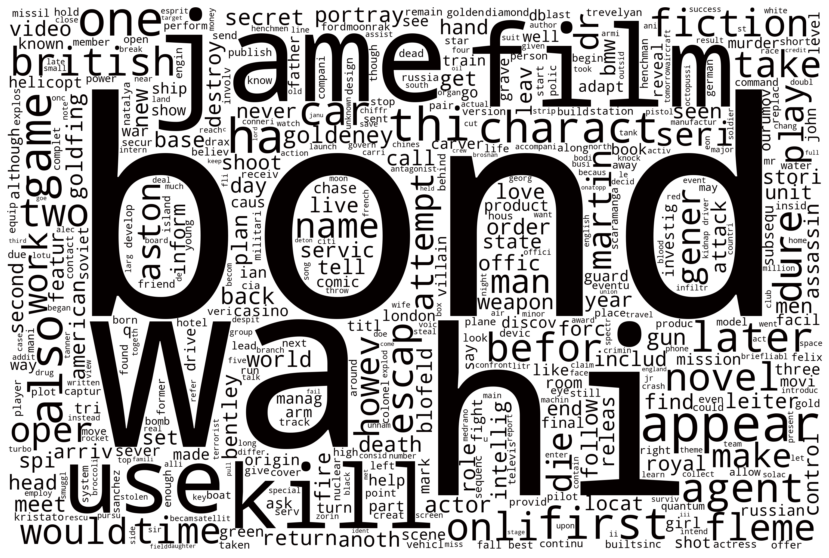

In [18]:
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

sums = data.sum(axis = 0)

wordcloud = WordCloud(background_color="white", width=3000, height=2000, max_words=500).generate_from_frequencies(sums)
wordcloud.recolor(color_func = black_color_func)

# Display the generated image:
plt.figure(figsize=[15,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Similarities<a name="similarities"></a> 

## TF-IDF form 

Let's start to create our TF-IDF form.

IDF need binary representation.

In [24]:
N = data.shape[0]
print(N)
dfi = data.astype(bool).sum(axis = 0)

1216


## IDF

In [25]:
IDF = DataFrame(dfi, columns=['count'])
IDF['count'] = IDF['count'].apply(lambda x: np.log(N/x))
IDF = IDF.transpose()
IDF

,abandon,abduct,abil,abl,aboard,abov,academi,accept,access,accid,...,wrote,xenia,yacht,year,yet,york,young,younger,zorin,zukovski
count,3.702125,3.845226,4.21295,2.826656,3.465736,3.576962,3.519803,3.736026,3.43976,4.0588,...,3.967828,3.845226,4.21295,2.059897,4.10759,3.414443,2.733874,4.395272,4.0588,4.0588


## TF-IDF

In [26]:
TFIDF = data * IDF.iloc[0]
TFIDF.head()

,abandon,abduct,abil,abl,aboard,abov,academi,accept,access,accid,...,wrote,xenia,yacht,year,yet,york,young,younger,zorin,zukovski
Site,,,,,,,,,,,,,,,,,,,,,
/wiki/Arab_Beauty_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.414443,0.0,0.0,0.0,0.0
/wiki/BMW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
/wiki/Annabel_Chung_(Marguerite_LeWars),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
/wiki/Heracles,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
/wiki/Casino_Royale_(novel),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [61]:
IDF[['bond', 'jame']]

,bond,jame
count,0.21068,0.381896


Calculate length for each vector.

In [27]:
lenDF = pd.DataFrame(np.sqrt(np.square(TFIDF.sum(axis=1))))
lenDF

,0
Site,
/wiki/Arab_Beauty_1,47.742718
/wiki/BMW,107.187747
/wiki/Annabel_Chung_(Marguerite_LeWars),247.143921
/wiki/Heracles,165.063248
/wiki/Casino_Royale_(novel),1130.980387
...,...
/wiki/Alura_McCall,182.284336
/wiki/BBC,122.223478
/wiki/Becoming_Bond_(documentary),203.712047


## Cosine similarity

Function that calculate most similar pages for list of pages.

We decided that treat all articles in input query as one. To do this we take centroid from all articles(add all values and then divide by number of articles). Then for our new query *q*, we will calculate cosine similarity for each document *d* that isn't one of our initial documents like this:

$\frac{\sum_{i=1}^{T} q_i*d_i}{\sqrt{\sum_{i=1}^{T} q_i^2}*\sqrt{\sum_{i=1}^{T} d_i^2}}$

where *T* is set of all terms and ${q_i}$ and ${d_i}$ are occurence of *i* terms in *q* or in *d*.



In [28]:
def get_most_similar_page(articles: List[str], df: DataFrame, lenDF: DataFrame) -> List[Tuple[str, float]]:
    values: List[Tuple[str, float]] = []
    selected_sites: DataFrame = DataFrame(df.loc[articles].sum()/len(articles)).transpose()
    selected_sum: DataFrame = DataFrame(np.sqrt(np.square(selected_sites.sum(axis=1)))).values[0]
        
    for ids, row in df.iterrows():
        if ids not in articles:
            sums = lenDF.loc[ids].values[0]
            if sums == 0: sums = 0.0001 #prevention of division by 0
            values.append((ids, ((selected_sites*row).sum(axis = 1).values[0]/(sums*selected_sum))[0]))
    values.sort(key = (lambda x: -x[1]))
    return values

# Examples<a name="examples"></a> 

For [1](https://jamesbond.fandom.com/wiki/Barbara_Jefford) and [2](https://jamesbond.fandom.com/wiki/Barbara_Carrera) our model returns  [1](https://jamesbond.fandom.com/wiki/Caterina_Murino), 
[2](https://jamesbond.fandom.com/wiki/Barbara_Bach), 
[3](https://jamesbond.fandom.com/wiki/Gemma_Arterton), 
[4](https://jamesbond.fandom.com/wiki/Daniela_Bianchi), 
[5](https://jamesbond.fandom.com/wiki/Claudine_Auger).

So for 2 sites of women actress, its return sites of other women actress.

In [29]:
get_most_similar_page(['/wiki/Barbara_Jefford', '/wiki/Barbara_Carrera'], TFIDF, lenDF)[:5]

[('/wiki/Caterina_Murino', 0.011829287781577253),
 ('/wiki/Barbara_Bach', 0.0094305856100971),
 ('/wiki/Gemma_Arterton', 0.008951579313357742),
 ('/wiki/Daniela_Bianchi', 0.008360180935687866),
 ('/wiki/Claudine_Auger', 0.008328869119222895)]

For [1](https://jamesbond.fandom.com/wiki/BMW_Z3) and [2](https://jamesbond.fandom.com/wiki/BMW_520i_(E34)) our model returns  [1](https://jamesbond.fandom.com/wiki/BMW), 
 [2](https://jamesbond.fandom.com/wiki/BMW_7_(E23)), 
 [3](https://jamesbond.fandom.com/wiki/BMW_R1200), 
 [4](https://jamesbond.fandom.com/wiki/Colt_Model_607), 
 [5](https://jamesbond.fandom.com/wiki/Cadillac_Series_62).

So for 2 sites of BMW, our model return 3 sites of other BMW and other car.

In [30]:
get_most_similar_page(['/wiki/BMW_Z3','/wiki/BMW_520i'], TFIDF, lenDF)[:5]

[('/wiki/BMW', 0.01630355906989989),
 ('/wiki/BMW_7_(E23)', 0.014297014185008951),
 ('/wiki/BMW_R1200', 0.0104014305483719),
 ('/wiki/Colt_Model_607', 0.008399130124326018),
 ('/wiki/Cadillac_Series_62', 0.008376157542796605)]

For [1](https://jamesbond.fandom.com/wiki/Blade-Rise_Industries) and [2](https://jamesbond.fandom.com/wiki/Blutbanner) and [3](https://jamesbond.fandom.com/wiki/D-8_armoured_car) or model returns [1](https://jamesbond.fandom.com/wiki/BR-12_mortar),
[2](https://jamesbond.fandom.com/wiki/Allworld_(airship)),
[3](https://jamesbond.fandom.com/wiki/Cold_War),
[4](https://jamesbond.fandom.com/wiki/Hepworth_Blade),
[5](https://jamesbond.fandom.com/wiki/Herta_Axmann).

So for 3 articles about high  nerd level novel, it returns 4 articles of same fashion.  

In [31]:
get_most_similar_page(['/wiki/Blade-Rise_Industries', '/wiki/Blutbanner', '/wiki/D-8_armoured_car'], TFIDF, lenDF)[:5]

[('/wiki/BR-12_mortar', 0.01705863268412726),
 ('/wiki/Allworld_(airship)', 0.015157802797289122),
 ('/wiki/Cold_War', 0.007505200696103857),
 ('/wiki/Hepworth_Blade', 0.0069109591285060595),
 ('/wiki/Herta_Axmann', 0.006489640090724269)]

For article about movie [Goldenfinger](https://jamesbond.fandom.com/wiki/Goldfinger_(film)) our model returns article about Goldfinger himself, theme song of the movie, actor from the movie, and some character from novel about Goldfinger.

In [32]:
get_most_similar_page(['/wiki/Goldfinger_(film)'], TFIDF, lenDF)[:5]

[('/wiki/Harold_Sakata', 0.01308928254755118),
 ('/wiki/Goldfinger', 0.01075611880908941),
 ('/wiki/Auric_Goldfinger', 0.009863140820840425),
 ('/wiki/Goldfinger_(song)', 0.005611302583028508),
 ('/wiki/Ethel_Du_Pont', 0.005185066944705639)]

## Visualizations

In [203]:
sample1 = get_most_similar_page(['/wiki/Barbara_Jefford'], TFIDF, lenDF)
sample2 = get_most_similar_page(['/wiki/Barbara_Carrera'], TFIDF, lenDF)

df1 = pd.DataFrame(sample1, columns=[0, 'Barbara Jefford']).set_index(0)
df2 = pd.DataFrame(sample2, columns=[0, 'Barbara Carrera']).set_index(0)

df_finnal = pd.concat([df1, df2], axis=1, join="inner")

solution = ['/wiki/Caterina_Murino', '/wiki/Barbara_Bach','/wiki/Gemma_Arterton','/wiki/Daniela_Bianchi', '/wiki/Claudine_Auger', ]
df_solution = df_finnal.loc[solution]

df_finnal = df_finnal.reset_index().rename(columns={0: 'Site'})
# df_solution .index.name = 'Site'
df_solution = df_solution.reset_index().rename(columns={0: 'Site'})

df_finnal 

,Site,Barbara Jefford,Barbara Carrera
0,/wiki/Eric_Pohlmann,0.021440,0.000028
1,/wiki/From_Russia_with_Love_(Film),0.021027,0.001166
2,/wiki/Belgium,0.019713,0.000000
3,/wiki/Daniela_Bianchi,0.019202,0.005647
4,/wiki/Barbara_Bach,0.017168,0.007494
...,...,...,...
1209,/wiki/Bernardo_Hertogs,0.000000,0.000000
1210,/wiki/Double_O_Trilogy,0.000000,0.000000
1211,/wiki/Gustav_Graves/Gallery,0.000000,0.000000
1212,/wiki/Hanafuda,0.000000,0.000000


In [202]:
df_solution

,Site,Barbara Jefford,Barbara Carrera
0,/wiki/Caterina_Murino,0.016490,0.010663
1,/wiki/Barbara_Bach,0.017168,0.007494
2,/wiki/Gemma_Arterton,0.012037,0.008179
3,/wiki/Daniela_Bianchi,0.019202,0.005647
4,/wiki/Claudine_Auger,0.009394,0.008062


In [211]:
fig = px.scatter(df_finnal, x='Barbara Jefford', y='Barbara Carrera', 
                hover_data={'Site': True,
                                            'Barbara Jefford': False,
                                            'Barbara Carrera': False}, 
                template='simple_white', color_discrete_sequence=px.colors.qualitative.Alphabet)
for i in range(5):
    
    fig.add_trace(go.Scatter(x=[df_solution['Barbara Jefford'].values.tolist()[i]], 
                             y=[df_solution['Barbara Carrera'].values.tolist()[i]], 
                             mode = 'markers',
                             marker_symbol = 'star',
                             marker_size = 15,
                             hoverinfo = 'skip',
                             name = df_solution['Site'].values.tolist()[i]))
fig.show()

For proving of correctness of our model(cosine simmilarity of average of query), let's check how it work when we compere it with classical cosine simmilarity, which is well establish as working. 

And we can obsereve that it is works as it should be! All our results are outstanding from others sites.

Now lets check which words have biggest impact on choosing these sites.

First lets choose from our TF-IDF matrix only these rows which contain either our query, or sites return by our model.
Then drop all columns which have zero in all query, and then drop all columns which have zeros in all sites return by our model.

In [193]:
check_df = TFIDF.loc[['/wiki/Barbara_Jefford', '/wiki/Barbara_Carrera']+solution]
check_df = check_df.drop(columns = check_df.columns[check_df.loc[solution].eq(0).mean()>0.999])
check_df = check_df.drop(columns = check_df.columns[check_df.loc[['/wiki/Barbara_Jefford', '/wiki/Barbara_Carrera']].eq(0).mean()>0.999])
check_df

,actress,also,american,barbara,best,bond,born,british,earn,film,...,play,product,role,royal,russia,sinc,spi,tatiana,thunderbal,wa
Site,,,,,,,,,,,,,,,,,,,,,
/wiki/Barbara_Jefford,2.625985,0.000000,0.000000,4.330733,2.648975,0.421361,2.518355,1.341271,0.000000,2.159446,...,1.765784,2.22052,2.307532,2.22052,2.549445,0.000000,1.835464,4.538373,3.232121,0.000000
/wiki/Barbara_Carrera,10.503941,2.566478,3.580232,4.330733,5.297950,0.421361,5.036709,0.000000,11.653339,3.599077,...,5.297352,0.00000,11.537658,0.00000,0.000000,5.207025,0.000000,0.000000,0.000000,0.727971
/wiki/Caterina_Murino,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.719815,...,1.765784,0.00000,2.307532,2.22052,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
/wiki/Barbara_Bach,2.625985,0.000000,1.790116,8.661467,0.000000,0.421361,2.518355,0.000000,0.000000,0.719815,...,0.000000,0.00000,0.000000,0.00000,0.000000,2.603512,3.670928,0.000000,0.000000,0.000000
/wiki/Gemma_Arterton,2.625985,0.000000,0.000000,0.000000,0.000000,0.000000,2.518355,1.341271,0.000000,0.000000,...,3.531568,2.22052,2.307532,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
/wiki/Daniela_Bianchi,2.625985,0.000000,0.000000,0.000000,2.648975,0.421361,0.000000,0.000000,0.000000,0.719815,...,0.000000,0.00000,2.307532,0.00000,2.549445,0.000000,0.000000,4.538373,0.000000,0.000000
/wiki/Claudine_Auger,2.625985,1.283239,0.000000,0.000000,2.648975,0.421361,0.000000,0.000000,3.884446,0.719815,...,0.000000,0.00000,2.307532,0.00000,0.000000,0.000000,0.000000,0.000000,3.232121,0.727971


Again combine our query into one row. 

Then create new matrix, in which we will hold perecentege share of each word in choosing these site.

In [194]:
temp = check_df.loc[['/wiki/Barbara_Jefford', '/wiki/Barbara_Carrera']].sum(axis=0)/2
res_df = temp * check_df.loc[solution]
some_sum = res_df.sum(axis=1)
for col in solution:
    res_df.loc[col] = ((res_df.loc[col]/some_sum[col])*100)
res_df

,actress,also,american,barbara,best,bond,born,british,earn,film,...,play,product,role,royal,russia,sinc,spi,tatiana,thunderbal,wa
Site,,,,,,,,,,,,,,,,,,,,,
/wiki/Caterina_Murino,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.748386,...,23.313856,0.000000,59.720784,9.216975,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
/wiki/Barbara_Bach,17.592726,0.000000,3.270175,38.279076,0.000000,0.181183,9.708085,0.000000,0.000000,2.115002,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.917161,3.437956,0.00000,0.000000,0.000000
/wiki/Gemma_Arterton,29.437223,0.000000,0.000000,0.000000,0.000000,0.000000,16.244161,1.535943,0.000000,0.000000,...,21.296459,4.209705,27.276510,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
/wiki/Daniela_Bianchi,26.177304,0.000000,0.000000,0.000000,15.982593,0.269593,0.000000,0.000000,0.000000,3.147043,...,0.000000,0.000000,24.255871,0.000000,4.934711,0.000000,0.000000,15.63762,0.000000,0.000000
/wiki/Claudine_Auger,21.636823,2.066732,0.000000,0.000000,13.210395,0.222832,0.000000,0.000000,28.406544,2.601185,...,0.000000,0.000000,20.048665,0.000000,0.000000,0.000000,0.000000,0.00000,6.555626,0.332558


Now for purpose of visulation, we need to transform our dateframe

In [195]:
res_df = res_df.reset_index()
res_df = res_df.melt(id_vars='Site', var_name='word', value_name='count')
res_df

,Site,word,count
0,/wiki/Caterina_Murino,actress,0.000000
1,/wiki/Barbara_Bach,actress,17.592726
2,/wiki/Gemma_Arterton,actress,29.437223
3,/wiki/Daniela_Bianchi,actress,26.177304
4,/wiki/Claudine_Auger,actress,21.636823
...,...,...,...
125,/wiki/Caterina_Murino,wa,0.000000
126,/wiki/Barbara_Bach,wa,0.000000
127,/wiki/Gemma_Arterton,wa,0.000000
128,/wiki/Daniela_Bianchi,wa,0.000000


In [196]:
fig = px.bar(res_df, x="Site", y="count", color="word", text="word", 
                template='simple_white', height=500, color_discrete_sequence=px.colors.qualitative.Alphabet)

fig.update_layout(showlegend=False)3
fig.update_xaxes(showline=False)

fig.show()

**Vous voilà!** Now we can easly see which words have biggest impact on choosing given  
